In [1]:
import pandas as pd
from collections import Counter
import numpy as np
import math
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
%matplotlib inline
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/justinchen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
dataset = pd.read_csv('/Users/justinchen/Desktop/AARD Datasets/mental_health_subreddits_dataset.csv')

In [97]:
sample = dataset.sample(45000)
sample.head()

,Unnamed: 0,subreddit.name,created_utc,body,sentiment
34724,14656403,anxiety,1594040602,"This Could Be the Coronavirus' ""Achilles Heel,...",0.9119
38385,15621798,anxiety,1590530784,It looks like you've mentioned COVID-19 in you...,0.8434
7577,4569307,anxiety,1624138728,That is awesome! I am happy for you. \n\nFor m...,0.9697
41715,16483616,anxiety,1587532059,It looks like you've mentioned COVID-19 in you...,0.8434
29422,13175345,suicidewatch,1598294613,Might have the covid foo drink alot of water. ...,0.4404


In [5]:
count = Counter()
for index, row in sample.iterrows():
    if row['subreddit.name'] == 'anxiety':
        count['anxiety'] += 1
    if row['subreddit.name'] == 'depression':
        count['depression'] += 1
    if row['subreddit.name'] == 'suicidewatch':
        count['SuicideWatch'] += 1
    if row['subreddit.name'] == 'mentalhealth':
        count['mentalhealth'] += 1
    if row['subreddit.name'] == 'covid19_support':
        count['COVID19_support'] += 1
count

Counter({'depression': 5749,
         'mentalhealth': 3256,
         'COVID19_support': 15645,
         'SuicideWatch': 3967,
         'anxiety': 16383})

## Preprocessing

In [8]:
import re
import demoji

In [9]:
def pre_cleaning(text):
    line=re.sub(r"\Bu/\w+", "USERNAME", text) #replace username with USERNAME
    line = demoji.replace(line, repl=' ')
    return line

In [99]:
#removing stopwords and urls, stemming, making lowercase 
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

def cleaning(text):
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            tokens.append(stemmer.stem(token))
    return " ".join(tokens)

In [11]:
def post_cleaning(text):
    # Remove all the special characters
    processed_feature = re.sub(r'\W', ' ',text)

    # remove all single characters
    processed_feature= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature)

    # Remove single characters from the start
    processed_feature = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_feature) 
    
    #remove digits
    processed_feature = re.sub("^\d+\s|\s\d+\s|\s\d+$", " ", processed_feature)

    # Substituting multiple spaces with single space
    processed_feature = re.sub(r'\s+', ' ', processed_feature, flags=re.I)

    return processed_feature

In [98]:
#above functions combined
def preprocessing(text):
    line = pre_cleaning(text)
    line = cleaning(line)
    line = post_cleaning (line)
    return line

In [100]:
sample.body = sample.body.apply(lambda x: preprocessing(x))

In [84]:
sample.head()

,Unnamed: 0,subreddit.name,created_utc,body,sentiment
3220,2164843,covid19_support,1630182140,know realli hard right feel lot thwart expect ...,-0.9543
3072,2072480,covid19_support,1630359602,feel self conscious mask place anyway decid an...,-0.9829
43854,17155415,anxiety,1585489783,brave cystic fibrosi suffer beat coronavirus i...,-0.3699
30956,13583177,mentalhealth,1597004249,wish everyon could know servic vari region may...,0.9878
44457,17350201,covid19_support,1584943369,bad idea might take get use day liter look cov...,0.5773


In [101]:
for sentiment in sample['sentiment']:
    if sentiment > 0:
        sample['sentiment'].replace({sentiment : 'positive'}, inplace=True)
    if sentiment < 0:
        sample['sentiment'].replace({sentiment : 'negative'}, inplace=True)
    else:
        sample['sentiment'].replace({sentiment : 'neutral'}, inplace=True)

Text(0.5, 1.0, 'Sentiment Data Distribution')

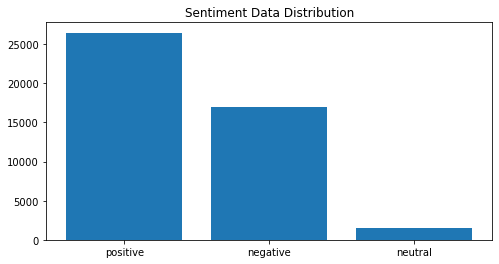

In [86]:
#Graphing
val_count = sample.sentiment.value_counts()
plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Sentiment Data Distribution")

In [87]:
sample.head()

,Unnamed: 0,subreddit.name,created_utc,body,sentiment
3220,2164843,covid19_support,1630182140,know realli hard right feel lot thwart expect ...,negative
3072,2072480,covid19_support,1630359602,feel self conscious mask place anyway decid an...,negative
43854,17155415,anxiety,1585489783,brave cystic fibrosi suffer beat coronavirus i...,negative
30956,13583177,mentalhealth,1597004249,wish everyon could know servic vari region may...,positive
44457,17350201,covid19_support,1584943369,bad idea might take get use day liter look cov...,positive


In [18]:
from sklearn.model_selection import train_test_split

In [102]:
 # Splits Dataset into Training and Testing set
train_size = 0.8
train_data, test_data = train_test_split(sample, test_size=1-train_size, random_state=42, shuffle=True)
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 36000
Test Data size 9000


## Vectorizing

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [103]:
vectorizer = TfidfVectorizer(max_features=10000,
                             min_df = 5,
                             max_df = 0.8,
                             sublinear_tf = True,
                             use_idf = True)
vectorizer.fit(train_data.body.to_list())
x_train = vectorizer.transform(train_data.body.to_list())
x_test = vectorizer.transform(test_data.body.to_list())

In [90]:
print("x_train Shape:",x_train.shape)
print("x_test Shape:",x_test.shape)

x_train Shape: (36000, 8367)
x_test Shape: (9000, 8367)


In [23]:
from sklearn.preprocessing import LabelEncoder

In [104]:
encoder = LabelEncoder() #https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html
encoder.fit(train_data.sentiment.to_list())

y_train = encoder.transform(train_data.sentiment.to_list())
y_test = encoder.transform(test_data.sentiment.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (36000, 1)
y_test shape: (9000, 1)


## Random Forest Model

In [25]:
from sklearn.ensemble import RandomForestClassifier

In [105]:
model = RandomForestClassifier()
model.fit(x_train, y_train.ravel())
predicted_labels = model.predict(x_test)
print ('Accuracy:', model.score(x_test, y_test))

Accuracy: 0.7661111111111111


## Feature Importances

In [26]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree
from sklearn.tree import export_graphviz

In [ ]:
from sklearn.tree import export_text
for tree in model.estimators_:
    text_representation = export_text(tree, feature_names = vectorizer.get_feature_names())
    print(text_representation)

In [59]:
import graphviz
# DOT data
for tree in model.estimators_:
    dot_data = export_graphviz(tree, out_file=None, 
                                feature_names=vectorizer.get_feature_names(),  
                                class_names=['negative', 'neutral', 'positive'],
                                filled=True)

# Draw graph
graph = graphviz.Source(dot_data, format="png") 

/Users/justinchen/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [61]:
graph.render("decision_tree_COVID")

'decision_tree_COVID.png'

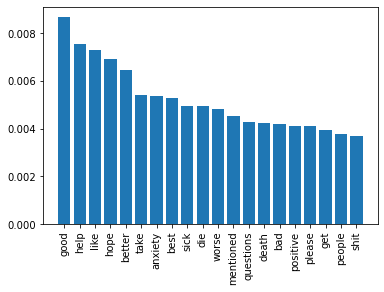

In [45]:
# Get feature importances from our random forest model
importances = model.feature_importances_

# Get the index of importances from greatest importance to least
sorted_index = np.argsort(importances)[::-1]
indices = sorted_index[0:20]
x = range(len(indices))

# Create tick labels
features = vectorizer.get_feature_names()
labels = np.array(features)[indices]
plt.bar(x, importances[indices], tick_label=labels)

# Rotate tick labels to vertical
plt.xticks(rotation=90)
plt.show()